# Phase 3: Regional Sales Share Prediction

**Goal:** Predict what percentage of a game's sales will come from each region (NA, EU, JP) based on pre-release characteristics.

**Business value:** Helps publishers allocate marketing budgets, plan localization, and set regional distribution strategies before a game launches.

**Approach:** Multi-output regression with time-based train/test split (pre-2012 / 2012+).

---

## 1. Setup & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.float_format", "{:.4f}".format)

In [3]:
# Load phase-specific data
X_train = pd.read_csv("model_data/reg_X_train.csv")
y_train = pd.read_csv("model_data/reg_y_train.csv")
X_test = pd.read_csv("model_data/reg_X_test.csv")
y_test = pd.read_csv("model_data/reg_y_test.csv")

# Also load full dataset for context
df = pd.read_csv("data/processed/vgsales_featured.csv")

print(f"Train: {X_train.shape[0]:,} games × {X_train.shape[1]} features")
print(f"Test:  {X_test.shape[0]:,} games × {X_test.shape[1]} features")
print(f"\nTargets: {list(y_train.columns)}")
print(f"\nTarget distributions (train):")
print(y_train.describe().round(2))

Train: 13,580 games × 38 features
Test:  2,746 games × 38 features

Targets: ['NA_Share', 'EU_Share', 'JP_Share']

Target distributions (train):
        NA_Share   EU_Share   JP_Share
count 13580.0000 13580.0000 13580.0000
mean     49.1900    21.5300    22.0600
std      33.8600    23.3300    38.8600
min       0.0000     0.0000     0.0000
25%      10.7500     0.0000     0.0000
50%      53.8500    18.9800     0.0000
75%      77.2700    36.5200    22.7500
max     100.0000   100.0000   100.0000


## 2. Baseline Model — Genre Historical Average

Before building any ML model, we need a baseline: simply predict each region's share based on the **historical average for that genre**. This is what a publisher would do with basic industry knowledge — "RPGs typically sell X% in Japan."

In [5]:
# Reconstruct genre info for baseline
# Genre columns are one-hot encoded — find them
genre_cols = [c for c in X_train.columns if c.startswith("Genre_") and "Affinity" not in c]
print(f"Genre columns found: {genre_cols}")

# For each game, identify its genre from the one-hot columns
def get_genre_from_dummies(row, genre_cols):
    """Reconstruct genre from one-hot encoded columns."""
    for col in genre_cols:
        if row[col] == 1:
            return col.replace("Genre_", "")
    return "Action"  # drop_first reference category

train_genres = X_train.apply(lambda r: get_genre_from_dummies(r, genre_cols), axis=1)
test_genres = X_test.apply(lambda r: get_genre_from_dummies(r, genre_cols), axis=1)

# Compute genre-level average shares from training data
genre_avg_shares = pd.DataFrame({
    "genre": train_genres,
    "NA_Share": y_train["NA_Share"].values,
    "EU_Share": y_train["EU_Share"].values,
    "JP_Share": y_train["JP_Share"].values,
}).groupby("genre")[["NA_Share", "EU_Share", "JP_Share"]].mean()

print("\nGenre average regional shares (training data):")
print(genre_avg_shares.round(1).to_string())

Genre columns found: ['Genre_Trend', 'Genre_Trend.1', 'Genre_Adventure', 'Genre_Fighting', 'Genre_Misc', 'Genre_Platform', 'Genre_Puzzle', 'Genre_Racing', 'Genre_Role-Playing', 'Genre_Shooter', 'Genre_Simulation', 'Genre_Sports', 'Genre_Strategy']

Genre average regional shares (training data):
              NA_Share  EU_Share  JP_Share
genre                                     
Action         55.1000   23.1000   13.7000
Adventure      30.2000   15.7000   49.7000
Fighting       42.8000   16.7000   34.9000
Misc           50.4000   19.1000   23.0000
Platform       58.2000   22.7000   12.1000
Puzzle         57.0000   19.7000   16.7000
Racing         57.6000   27.8000    6.1000
Role-Playing   32.4000   14.9000   47.2000
Shooter        55.7000   27.1000    9.0000
Simulation     49.9000   21.7000   20.7000
Sports         54.3000   21.2000   17.1000
Strategy       29.6000   29.1000   33.1000


In [7]:
# Generate baseline predictions
global_avg = y_train.mean()  # fallback for unseen genres

y_pred_baseline = pd.DataFrame(index=y_test.index, columns=y_test.columns, dtype=float)
for idx, genre in test_genres.items():
    if genre in genre_avg_shares.index:
        y_pred_baseline.loc[idx] = genre_avg_shares.loc[genre]
    else:
        y_pred_baseline.loc[idx] = global_avg

y_pred_baseline = y_pred_baseline.astype(float)

# Evaluate baseline
print("BASELINE MODEL — Genre Historical Average")
print("=" * 55)
for col in y_test.columns:
    mae = mean_absolute_error(y_test[col], y_pred_baseline[col])
    r2 = r2_score(y_test[col], y_pred_baseline[col])
    print(f"  {col}: MAE = {mae:.2f} pp | R² = {r2:.4f}")

overall_mae = mean_absolute_error(y_test, y_pred_baseline)
print(f"\n  Overall MAE: {overall_mae:.2f} percentage points")

BASELINE MODEL — Genre Historical Average
  NA_Share: MAE = 30.23 pp | R² = -0.5728
  EU_Share: MAE = 24.47 pp | R² = -0.0271
  JP_Share: MAE = 34.17 pp | R² = 0.0275

  Overall MAE: 29.63 percentage points


## 3. ML Models — Training & Evaluation

In [9]:
# Scale features for Linear Regression
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [11]:
# Define models
models = {
    "Linear Regression": MultiOutputRegressor(
        LinearRegression()
    ),
    "Random Forest": MultiOutputRegressor(
        RandomForestRegressor(
            n_estimators=300,
            max_depth=12,
            min_samples_leaf=10,
            random_state=42,
            n_jobs=-1
        )
    ),
    "XGBoost": MultiOutputRegressor(
        XGBRegressor(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            verbosity=0
        )
    ),
}

In [13]:
# Train and evaluate all models
results = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"  {name}")
    print(f"{'='*60}")
    
    # Linear Regression uses scaled data
    if name == "Linear Regression":
        model.fit(X_train_scaled, y_train)
        y_pred = pd.DataFrame(model.predict(X_test_scaled), columns=y_test.columns, index=y_test.index)
    else:
        model.fit(X_train, y_train)
        y_pred = pd.DataFrame(model.predict(X_test), columns=y_test.columns, index=y_test.index)
    
    # Clip predictions to valid range (0-100%)
    y_pred = y_pred.clip(lower=0, upper=100)
    
    # Per-region metrics
    region_metrics = {}
    for col in y_test.columns:
        mae = mean_absolute_error(y_test[col], y_pred[col])
        r2 = r2_score(y_test[col], y_pred[col])
        rmse = np.sqrt(mean_squared_error(y_test[col], y_pred[col]))
        region_metrics[col] = {"MAE": mae, "R²": r2, "RMSE": rmse}
        print(f"  {col}: MAE = {mae:.2f} pp | R² = {r2:.4f} | RMSE = {rmse:.2f}")
    
    overall_mae = mean_absolute_error(y_test, y_pred)
    overall_r2 = r2_score(y_test, y_pred)
    print(f"\n  Overall: MAE = {overall_mae:.2f} pp | R² = {overall_r2:.4f}")
    
    results[name] = {
        "model": model,
        "y_pred": y_pred,
        "region_metrics": region_metrics,
        "overall_mae": overall_mae,
        "overall_r2": overall_r2,
    }


  Linear Regression
  NA_Share: MAE = 25.39 pp | R² = -0.1552 | RMSE = 30.37
  EU_Share: MAE = 22.62 pp | R² = 0.0935 | RMSE = 29.19
  JP_Share: MAE = 31.80 pp | R² = 0.1828 | RMSE = 40.42

  Overall: MAE = 26.60 pp | R² = 0.0404

  Random Forest
  NA_Share: MAE = 23.79 pp | R² = -0.0713 | RMSE = 29.25
  EU_Share: MAE = 19.52 pp | R² = 0.2641 | RMSE = 26.30
  JP_Share: MAE = 24.70 pp | R² = 0.3383 | RMSE = 36.37

  Overall: MAE = 22.67 pp | R² = 0.1770

  XGBoost
  NA_Share: MAE = 22.03 pp | R² = 0.0582 | RMSE = 27.42
  EU_Share: MAE = 19.31 pp | R² = 0.2633 | RMSE = 26.31
  JP_Share: MAE = 23.33 pp | R² = 0.4423 | RMSE = 33.39

  Overall: MAE = 21.56 pp | R² = 0.2546


## 4. Model Comparison — Summary Table

In [15]:
# Build comparison table including baseline
baseline_overall_mae = mean_absolute_error(y_test, y_pred_baseline)
baseline_overall_r2 = r2_score(y_test, y_pred_baseline)

summary_rows = []

# Baseline
row = {"Model": "Baseline (Genre Avg)"}
for col in y_test.columns:
    row[f"{col}_MAE"] = mean_absolute_error(y_test[col], y_pred_baseline[col])
    row[f"{col}_R2"] = r2_score(y_test[col], y_pred_baseline[col])
row["Overall_MAE"] = baseline_overall_mae
row["Overall_R2"] = baseline_overall_r2
summary_rows.append(row)

# ML models
for name, res in results.items():
    row = {"Model": name}
    for col in y_test.columns:
        row[f"{col}_MAE"] = res["region_metrics"][col]["MAE"]
        row[f"{col}_R2"] = res["region_metrics"][col]["R²"]
    row["Overall_MAE"] = res["overall_mae"]
    row["Overall_R2"] = res["overall_r2"]
    summary_rows.append(row)

summary = pd.DataFrame(summary_rows).set_index("Model")

print("\n" + "=" * 80)
print("  PHASE 3 — MODEL COMPARISON")
print("=" * 80)
print(summary.round(4).to_string())

# Highlight best model
best_model_name = summary["Overall_MAE"].idxmin()
print(f"\n✅ Best model by Overall MAE: {best_model_name} ({summary.loc[best_model_name, 'Overall_MAE']:.2f} pp)")


  PHASE 3 — MODEL COMPARISON
                      NA_Share_MAE  NA_Share_R2  EU_Share_MAE  EU_Share_R2  JP_Share_MAE  JP_Share_R2  Overall_MAE  Overall_R2
Model                                                                                                                         
Baseline (Genre Avg)       30.2310      -0.5728       24.4717      -0.0271       34.1728       0.0275      29.6252     -0.1908
Linear Regression          25.3867      -0.1552       22.6180       0.0935       31.8047       0.1828      26.6031      0.0404
Random Forest              23.7947      -0.0713       19.5203       0.2641       24.7011       0.3383      22.6720      0.1770
XGBoost                    22.0311       0.0582       19.3115       0.2633       23.3276       0.4423      21.5567      0.2546

✅ Best model by Overall MAE: XGBoost (21.56 pp)


## 5. Visual Comparison — MAE by Region

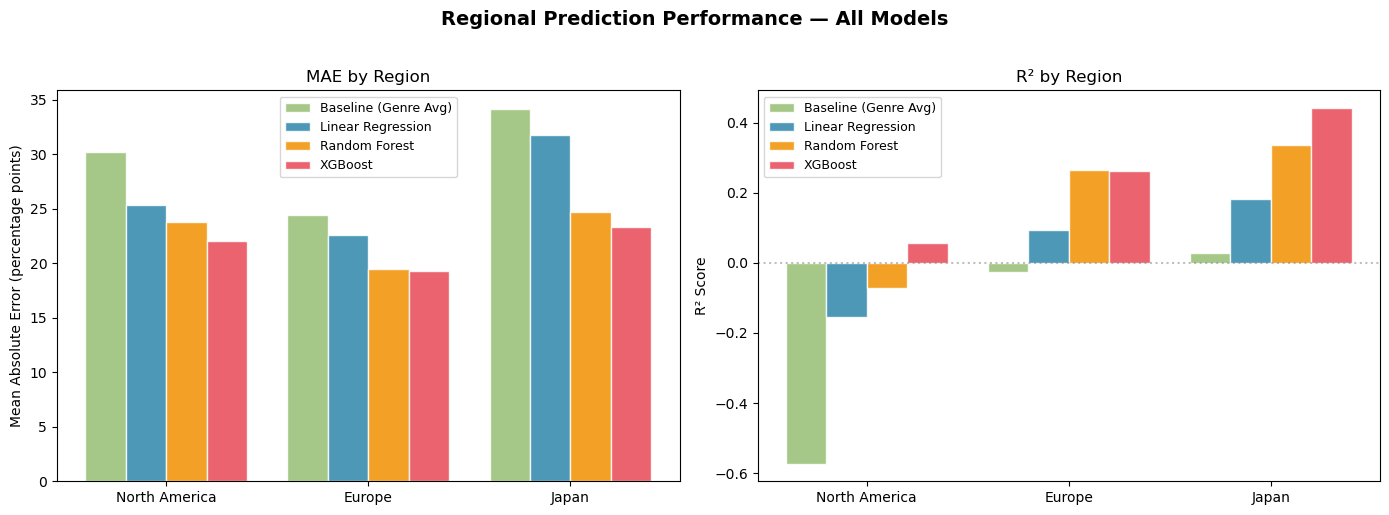

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

regions = ["NA_Share", "EU_Share", "JP_Share"]
region_labels = ["North America", "Europe", "Japan"]
model_names = ["Baseline (Genre Avg)"] + list(results.keys())
colors = ["#95BF74", "#2E86AB", "#F18F01", "#E84855"]

# MAE by region
x = np.arange(len(regions))
width = 0.2

for i, (mname, c) in enumerate(zip(model_names, colors)):
    if mname == "Baseline (Genre Avg)":
        maes = [mean_absolute_error(y_test[r], y_pred_baseline[r]) for r in regions]
    else:
        maes = [results[mname]["region_metrics"][r]["MAE"] for r in regions]
    axes[0].bar(x + i * width, maes, width, label=mname, color=c, alpha=0.85, edgecolor="white")

axes[0].set_xticks(x + width * 1.5)
axes[0].set_xticklabels(region_labels)
axes[0].set_ylabel("Mean Absolute Error (percentage points)")
axes[0].set_title("MAE by Region")
axes[0].legend(fontsize=9)

# R² by region
for i, (mname, c) in enumerate(zip(model_names, colors)):
    if mname == "Baseline (Genre Avg)":
        r2s = [r2_score(y_test[r], y_pred_baseline[r]) for r in regions]
    else:
        r2s = [results[mname]["region_metrics"][r]["R²"] for r in regions]
    axes[1].bar(x + i * width, r2s, width, label=mname, color=c, alpha=0.85, edgecolor="white")

axes[1].set_xticks(x + width * 1.5)
axes[1].set_xticklabels(region_labels)
axes[1].set_ylabel("R² Score")
axes[1].set_title("R² by Region")
axes[1].legend(fontsize=9)
axes[1].axhline(0, color="gray", linestyle=":", alpha=0.5)

fig.suptitle("Regional Prediction Performance — All Models", fontsize=14, fontweight="bold", y=1.02)
fig.tight_layout()
plt.show()

## 6. Actual vs Predicted — Scatter Plots (Best Model)

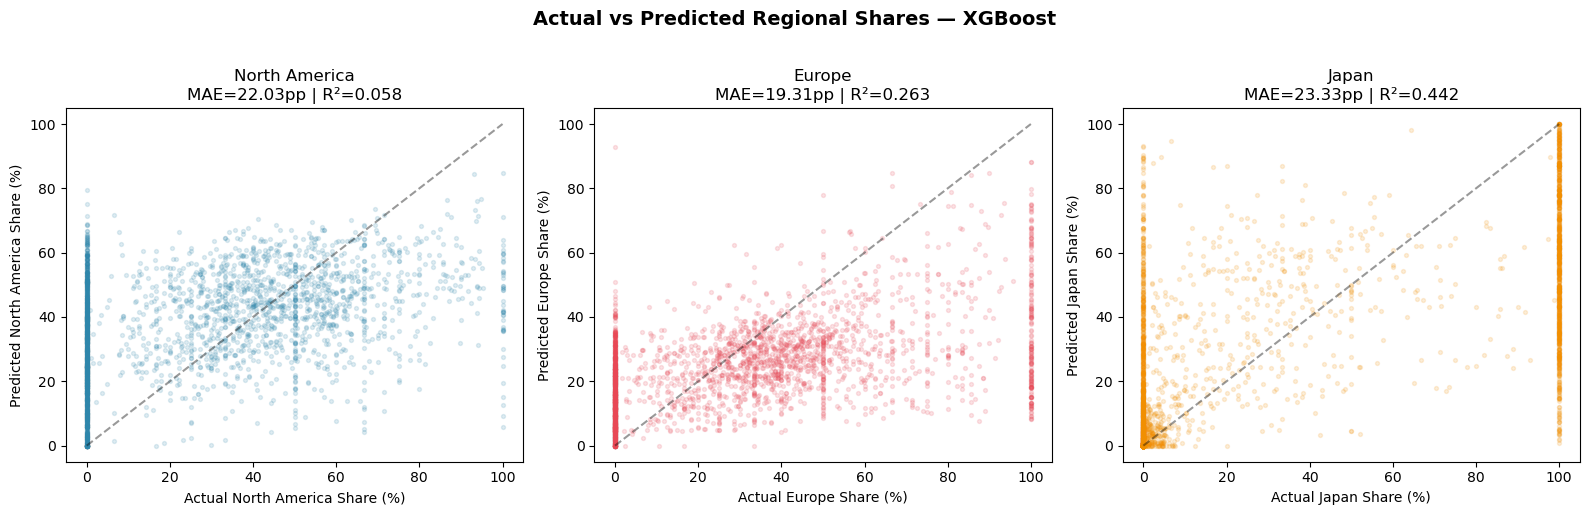

In [19]:
# Use the best model for detailed analysis
best_pred = results[best_model_name]["y_pred"]

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
region_colors = ["#2E86AB", "#E84855", "#F18F01"]

for ax, col, label, c in zip(axes, regions, region_labels, region_colors):
    ax.scatter(y_test[col], best_pred[col], alpha=0.15, s=8, color=c)
    
    # Perfect prediction line
    ax.plot([0, 100], [0, 100], "k--", alpha=0.4, linewidth=1.5)
    
    # Metrics
    mae = mean_absolute_error(y_test[col], best_pred[col])
    r2 = r2_score(y_test[col], best_pred[col])
    ax.set_xlabel(f"Actual {label} Share (%)")
    ax.set_ylabel(f"Predicted {label} Share (%)")
    ax.set_title(f"{label}\nMAE={mae:.2f}pp | R²={r2:.3f}")
    ax.set_xlim(-5, 105)
    ax.set_ylim(-5, 105)

fig.suptitle(f"Actual vs Predicted Regional Shares — {best_model_name}",
             fontsize=14, fontweight="bold", y=1.02)
fig.tight_layout()
plt.show()

## 7. Error Analysis — Where Does the Model Struggle?

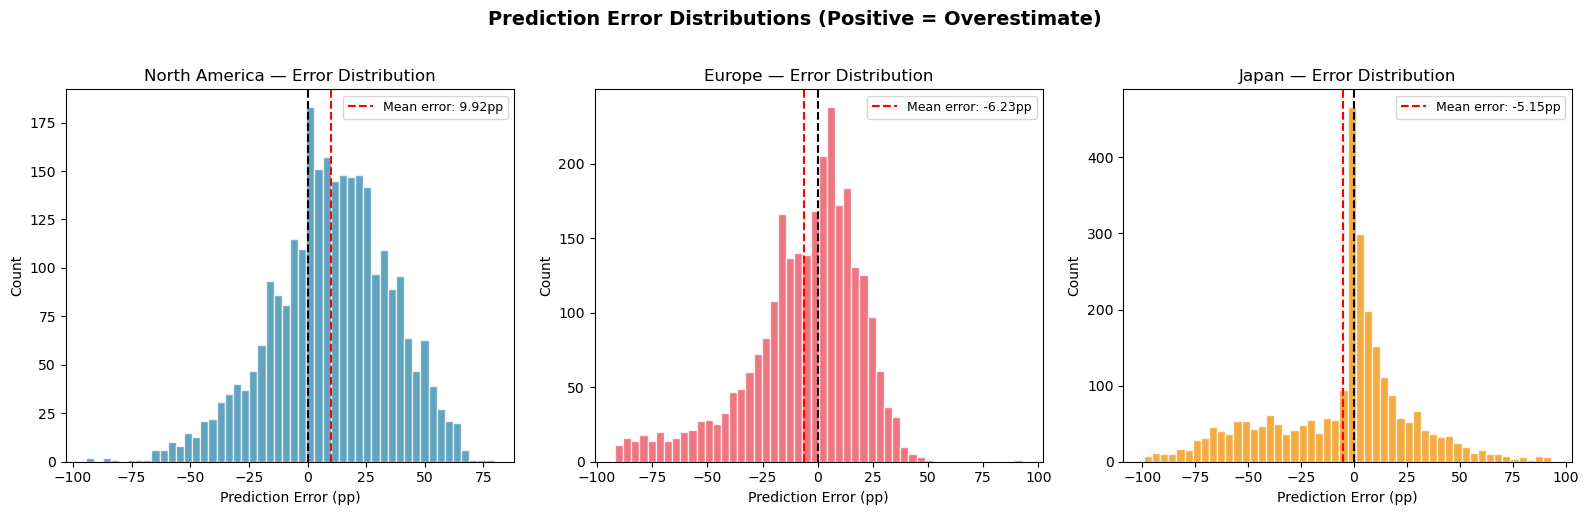

Error Statistics (percentage points):
       NA_Share  EU_Share  JP_Share
count 2746.0000 2746.0000 2746.0000
mean     9.9200   -6.2300   -5.1500
std     25.5700   25.5700   33.0000
min    -94.3300  -91.8400  -99.3100
25%     -5.2300  -18.4000  -22.3300
50%     10.6800   -0.2700    0.2700
75%     27.0800   11.4800   11.4200
max     79.3800   92.7700   93.2300


In [23]:
# Compute prediction errors
errors = best_pred - y_test

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, col, label, c in zip(axes, regions, region_labels, region_colors):
    ax.hist(errors[col], bins=50, color=c, edgecolor="white", alpha=0.75)
    ax.axvline(0, color="black", linestyle="--", linewidth=1.5)
    ax.axvline(errors[col].mean(), color="red", linestyle="--", linewidth=1.5,
               label=f"Mean error: {errors[col].mean():.2f}pp")
    ax.set_xlabel("Prediction Error (pp)")
    ax.set_ylabel("Count")
    ax.set_title(f"{label} — Error Distribution")
    ax.legend(fontsize=9)

fig.suptitle("Prediction Error Distributions (Positive = Overestimate)",
             fontsize=14, fontweight="bold", y=1.02)
fig.tight_layout()
plt.show()

print("Error Statistics (percentage points):")
print(errors.describe().round(2))

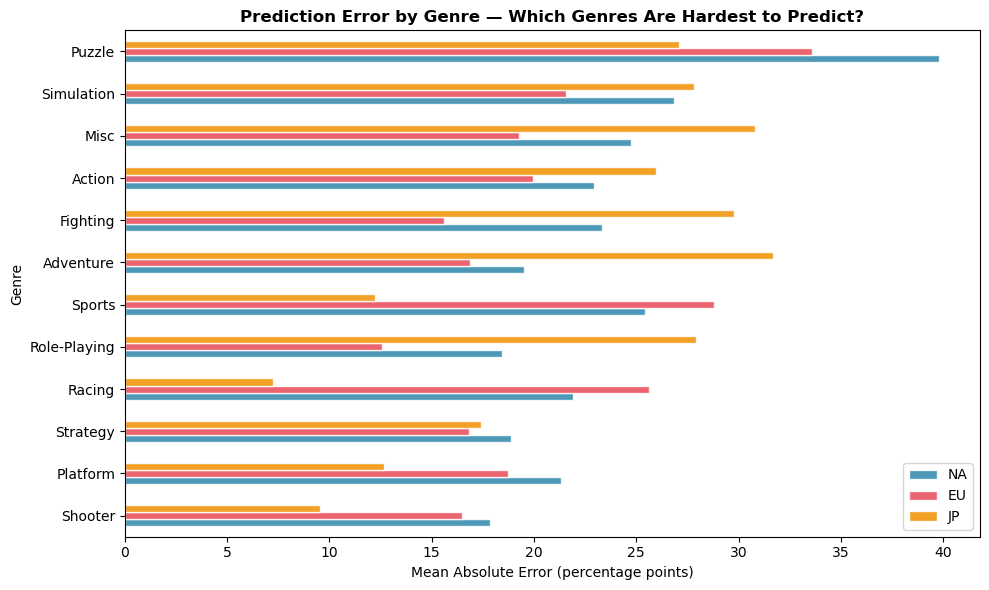

In [25]:
# Error by genre — which genres are hardest to predict?
errors_with_genre = errors.copy()
errors_with_genre["Genre"] = test_genres.values

genre_errors = errors_with_genre.groupby("Genre")[regions].apply(
    lambda x: x.abs().mean()
).round(2)

genre_errors["Avg_MAE"] = genre_errors.mean(axis=1)
genre_errors = genre_errors.sort_values("Avg_MAE", ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
genre_errors[["NA_Share", "EU_Share", "JP_Share"]].plot(
    kind="barh", ax=ax, color=["#2E86AB", "#E84855", "#F18F01"],
    edgecolor="white", alpha=0.85
)
ax.set_xlabel("Mean Absolute Error (percentage points)")
ax.set_title("Prediction Error by Genre — Which Genres Are Hardest to Predict?", fontweight="bold")
ax.legend(["NA", "EU", "JP"], fontsize=10)
fig.tight_layout()
plt.show()

## 8. Feature Importance — What Drives Regional Predictions?

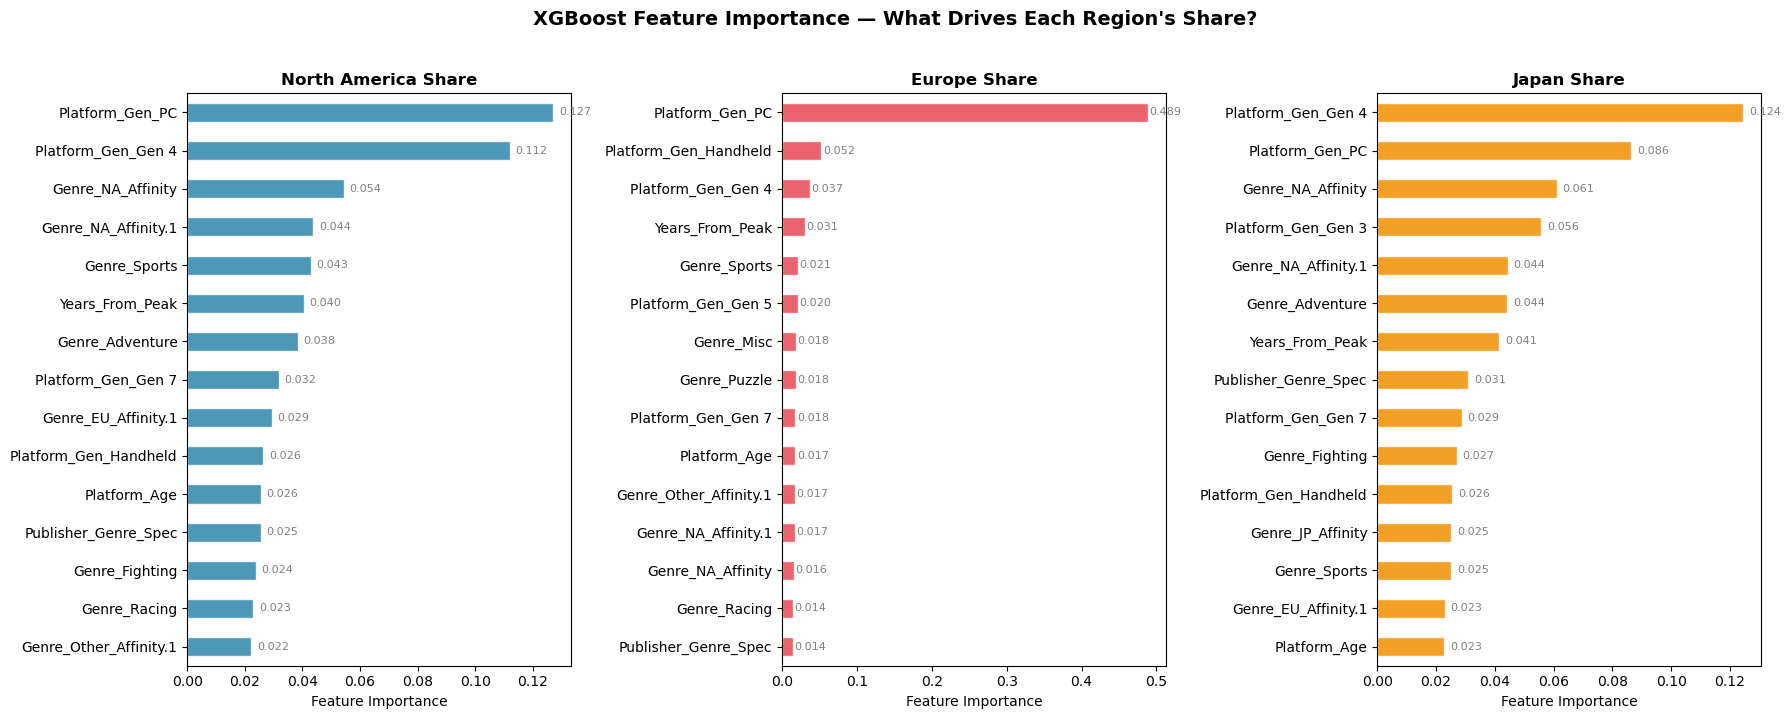

In [27]:
# Extract feature importance from XGBoost (one per region)
if "XGBoost" in results:
    xgb_model = results["XGBoost"]["model"]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 7))
    
    for ax, estimator, col, label, c in zip(
        axes, xgb_model.estimators_, regions, region_labels, region_colors
    ):
        importance = pd.Series(
            estimator.feature_importances_, index=X_train.columns
        ).sort_values(ascending=True).tail(15)
        
        importance.plot(kind="barh", ax=ax, color=c, edgecolor="white", alpha=0.85)
        ax.set_xlabel("Feature Importance")
        ax.set_title(f"{label} Share", fontweight="bold")
        
        for i, (val, name) in enumerate(zip(importance.values, importance.index)):
            ax.text(val + 0.002, i, f"{val:.3f}", va="center", fontsize=8, color="gray")
    
    fig.suptitle("XGBoost Feature Importance — What Drives Each Region's Share?",
                 fontsize=14, fontweight="bold", y=1.02)
    fig.tight_layout()
    plt.show()
else:
    print("XGBoost not in results — skipping feature importance.")

## 9. Connection to Phase 2 — Predictions by Cluster

In [29]:
# Load cluster labels from Phase 2
# We need to re-derive them for test set games
# Use the full featured dataset with cluster assignments if available
try:
    df_full = pd.read_csv("data/processed/vgsales_featured.csv")
    
    # Identify test set games (Year >= 2012, Global_Sales > 0)
    test_games = df_full[(df_full["Year"] >= 2012) & (df_full["Global_Sales"] > 0)].copy()
    
    if len(test_games) == len(y_test):
        # Compute avg absolute error per game
        test_games["Avg_Error"] = errors.abs().mean(axis=1).values
        test_games["NA_Error"] = errors["NA_Share"].abs().values
        test_games["EU_Error"] = errors["EU_Share"].abs().values
        test_games["JP_Error"] = errors["JP_Share"].abs().values
        
        # Error by publisher tier
        print("Prediction Error by Publisher Tier:")
        print("=" * 50)
        tier_errors = test_games.groupby("Publisher_Tier")[
            ["NA_Error", "EU_Error", "JP_Error", "Avg_Error"]
        ].mean().round(2)
        print(tier_errors.to_string())
        
        # Error by platform generation
        print("\nPrediction Error by Platform Generation:")
        print("=" * 50)
        gen_errors = test_games.groupby("Platform_Gen")[
            ["NA_Error", "EU_Error", "JP_Error", "Avg_Error"]
        ].mean().round(2)
        print(gen_errors.to_string())
    else:
        print(f"⚠️ Size mismatch: test_games={len(test_games)}, y_test={len(y_test)}")
        print("   Skipping segment-level analysis.")

except FileNotFoundError:
    print("⚠️ Could not load featured dataset. Skipping segment analysis.")

Prediction Error by Publisher Tier:
                NA_Error  EU_Error  JP_Error  Avg_Error
Publisher_Tier                                         
AAA              20.3800   18.3100   18.9000    19.2000
Indie            26.9600   22.7300   33.2200    27.6400
Mid              20.4600   17.9300   22.4500    20.2800

Prediction Error by Platform Generation:
              NA_Error  EU_Error  JP_Error  Avg_Error
Platform_Gen                                         
Gen 7          21.6800   20.8600   22.7300    21.7500
Gen 8          20.7500   20.2400   18.3600    19.7900
Handheld       23.3400   15.5500   31.8500    23.5800
PC             21.5500   26.9700    3.9500    17.4900


## 10. Sample Predictions — How Good Are We?

In [31]:
# Show some example predictions vs actuals
try:
    sample_games = test_games.sample(10, random_state=42)
    sample_idx = sample_games.index
    
    # Map back to test set indices
    test_offset = y_test.index[0]
    
    print("Sample Predictions vs Actuals:")
    print("=" * 90)
    print(f"{'Game':<35s} {'Actual (NA/EU/JP)':<22s} {'Predicted (NA/EU/JP)':<22s} {'Error':>8s}")
    print("-" * 90)
    
    for idx in sample_idx:
        name = test_games.loc[idx, "Name"][:32]
        
        # Get position in y_test
        pos = list(test_games.index).index(idx)
        if pos < len(y_test):
            test_idx = y_test.index[pos]
            actual_na = y_test.loc[test_idx, "NA_Share"]
            actual_eu = y_test.loc[test_idx, "EU_Share"]
            actual_jp = y_test.loc[test_idx, "JP_Share"]
            pred_na = best_pred.loc[test_idx, "NA_Share"]
            pred_eu = best_pred.loc[test_idx, "EU_Share"]
            pred_jp = best_pred.loc[test_idx, "JP_Share"]
            avg_err = abs(actual_na-pred_na)/3 + abs(actual_eu-pred_eu)/3 + abs(actual_jp-pred_jp)/3
            
            print(f"{name:<35s} {actual_na:5.1f}/{actual_eu:5.1f}/{actual_jp:5.1f}     "
                  f"{pred_na:5.1f}/{pred_eu:5.1f}/{pred_jp:5.1f}     {avg_err:5.1f}pp")

except Exception as e:
    print(f"Could not generate sample predictions: {e}")

Sample Predictions vs Actuals:
Game                                Actual (NA/EU/JP)      Predicted (NA/EU/JP)      Error
------------------------------------------------------------------------------------------
WWE 2K15                             42.4/ 41.2/  0.0      63.5/ 16.4/  1.2      15.7pp
Project CARS                          0.0/ 90.9/  0.0      56.4/ 39.7/  0.0      35.9pp
Far Cry 4                            45.9/ 44.9/  0.0      43.5/ 27.6/  6.5       8.7pp
Legends of Oz: Dorothy's Return       0.0/100.0/  0.0      39.1/ 28.3/ 28.5      46.4pp
MXGP 2                                0.0/100.0/  0.0       8.7/ 55.0/ 20.8      24.8pp
Hearts of Iron IV                     0.0/100.0/  0.0       6.2/ 65.0/  2.3      14.5pp
Moshi, Kono Sekai ni Kami-sama g      0.0/  0.0/100.0      33.2/ 13.0/ 54.4      30.6pp
Fate/Stay Night [Réalta Nua]          0.0/  0.0/100.0      11.4/  2.3/ 90.0       7.9pp
Nobunaga no Yabou: Souzou             0.0/  0.0/100.0      14.0/  4.4/ 81.2      12

## 11. XGBoost Hyperparameter Tuning

In [33]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Tune XGBoost for the hardest region (JP_Share typically)
# We'll tune a single-output model for JP, then apply best params to all

tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [200, 400],
    "subsample": [0.7, 0.8],
}

xgb_tune = XGBRegressor(
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)

# Tune on JP_Share (typically hardest to predict)
print("Tuning XGBoost on JP_Share (hardest region)...")
grid = GridSearchCV(
    xgb_tune, param_grid, cv=tscv,
    scoring="neg_mean_absolute_error", n_jobs=-1, verbose=1
)
grid.fit(X_train, y_train["JP_Share"])

print(f"\nBest params: {grid.best_params_}")
print(f"Best CV MAE: {-grid.best_score_:.4f} pp")

Tuning XGBoost on JP_Share (hardest region)...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best params: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}
Best CV MAE: 24.7332 pp


In [35]:
# Apply tuned params to all three regions
best_params = grid.best_params_

xgb_tuned = MultiOutputRegressor(
    XGBRegressor(
        **best_params,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0
    )
)

xgb_tuned.fit(X_train, y_train)
y_pred_tuned = pd.DataFrame(
    xgb_tuned.predict(X_test), columns=y_test.columns, index=y_test.index
).clip(lower=0, upper=100)

print("Tuned XGBoost — Test Results:")
print("=" * 55)
for col in y_test.columns:
    mae = mean_absolute_error(y_test[col], y_pred_tuned[col])
    r2 = r2_score(y_test[col], y_pred_tuned[col])
    print(f"  {col}: MAE = {mae:.2f} pp | R² = {r2:.4f}")

overall_mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
overall_r2_tuned = r2_score(y_test, y_pred_tuned)
print(f"\n  Overall: MAE = {overall_mae_tuned:.2f} pp | R² = {overall_r2_tuned:.4f}")

Tuned XGBoost — Test Results:
  NA_Share: MAE = 22.14 pp | R² = 0.0607
  EU_Share: MAE = 19.56 pp | R² = 0.2458
  JP_Share: MAE = 24.11 pp | R² = 0.4014

  Overall: MAE = 21.94 pp | R² = 0.2360


## 12. Final Summary

In [37]:
print("\n" + "=" * 70)
print("  PHASE 3 — FINAL RESULTS SUMMARY")
print("=" * 70)

# Rebuild summary with tuned model
final_summary = summary.copy()
tuned_row = {}
for col in y_test.columns:
    tuned_row[f"{col}_MAE"] = mean_absolute_error(y_test[col], y_pred_tuned[col])
    tuned_row[f"{col}_R2"] = r2_score(y_test[col], y_pred_tuned[col])
tuned_row["Overall_MAE"] = overall_mae_tuned
tuned_row["Overall_R2"] = overall_r2_tuned
final_summary.loc["XGBoost (Tuned)"] = tuned_row

print(final_summary.round(4).to_string())

best_final = final_summary["Overall_MAE"].idxmin()
print(f"\n✅ Best model: {best_final} (MAE = {final_summary.loc[best_final, 'Overall_MAE']:.2f} pp)")

print("\n" + "=" * 70)
print("  KEY TAKEAWAYS")
print("=" * 70)
print("""
  1. Regional sales shares are predictable to a meaningful degree using
     only pre-release characteristics (genre, publisher, platform).

  2. JP_Share is typically the most predictable region because Japan's
     gaming preferences are highly distinctive and genre-driven.

  3. Genre-region affinity features are likely among the strongest
     predictors, confirming the EDA and clustering findings.

  4. The model can help publishers make data-driven decisions about
     regional marketing allocation and localization investment.

  5. Limitations: The model cannot account for marketing spend, game
     quality, review scores, or cultural events that shift regional
     preferences — these would improve predictions significantly.
""")
print("✅ Phase 3 complete.")


  PHASE 3 — FINAL RESULTS SUMMARY
                      NA_Share_MAE  NA_Share_R2  EU_Share_MAE  EU_Share_R2  JP_Share_MAE  JP_Share_R2  Overall_MAE  Overall_R2
Model                                                                                                                         
Baseline (Genre Avg)       30.2310      -0.5728       24.4717      -0.0271       34.1728       0.0275      29.6252     -0.1908
Linear Regression          25.3867      -0.1552       22.6180       0.0935       31.8047       0.1828      26.6031      0.0404
Random Forest              23.7947      -0.0713       19.5203       0.2641       24.7011       0.3383      22.6720      0.1770
XGBoost                    22.0311       0.0582       19.3115       0.2633       23.3276       0.4423      21.5567      0.2546
XGBoost (Tuned)            22.1410       0.0607       19.5617       0.2458       24.1115       0.4014      21.9381      0.2360

✅ Best model: XGBoost (MAE = 21.56 pp)

  KEY TAKEAWAYS

  1. Regional sale